In [1]:
import numpy as np
import pandas as pd 
import glob
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from utils import procesar_metricas, summarize_metrics_by_group, summarize_metrics_for_plotting

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

In [2]:
models = glob.glob(os.path.join('./output/*', '*', 'test_metrics.toml'))

In [3]:
resultados = procesar_metricas(models)

In [4]:
summary_df = summarize_metrics_by_group(resultados)

In [5]:
df_plot = summarize_metrics_for_plotting(resultados)

In [6]:
df_plot['F1_Score_error_low'] = df_plot['F1_Score_mean'] - df_plot['F1_Score_p05']
df_plot['F1_Score_error_high'] = df_plot['F1_Score_p95'] - df_plot['F1_Score_mean']

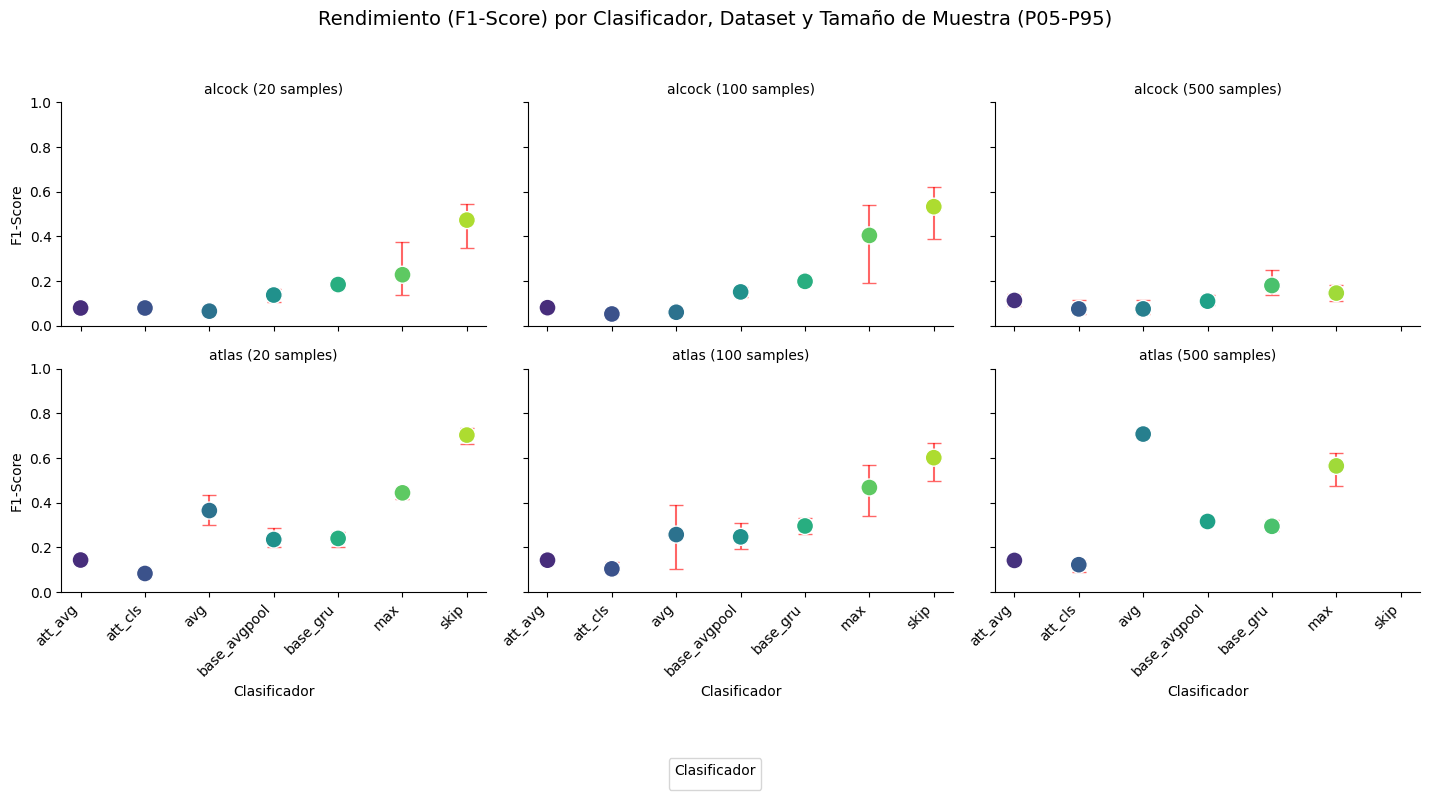

In [7]:
g = sns.FacetGrid(
    df_plot, 
    col="Dataset_Samples", 
    col_wrap=3, # Ajusta a 3 columnas para visualización si hay muchos grupos
    sharey=True, 
    height=4, 
    aspect=1.2
)

# Mapear el gráfico en cada faceta (Point Plot con barras de error personalizadas)
g.map_dataframe(
    # Usamos scatterplot para dibujar los puntos (Media)
    sns.scatterplot,
    x='Classifier', 
    y='F1_Score_mean', 
    hue='Classifier',
    s=150, 
    palette='viridis', 
    legend=False,
    zorder=3 # Asegura que los puntos estén sobre las barras de error
)

# Mapear las barras de error (matplotlib errorbar)
def plot_errorbar(data, color, **kwargs):
    # La función debe ejecutarse por cada grupo de faceta
    plt.errorbar(
        data['Classifier'], 
        data['F1_Score_mean'], 
        yerr=[data['F1_Score_error_low'], data['F1_Score_error_high']], 
        fmt='o', # Formato: un círculo ('o') para la media, aunque ya lo dibujamos con scatterplot
        capsize=5, # Tamaño de los topes de la barra
        color=color,
        alpha=0.6,
        zorder=2,
        elinewidth=1.5 # Ancho de la línea de error
    )

# Aplicar la función de barra de error al FacetGrid
g.map_dataframe(
    plot_errorbar, 
    color='red' # Usamos un color neutro para las barras
)


# Personalización del gráfico
g.set_axis_labels("Clasificador", "F1-Score")
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Rendimiento (F1-Score) por Clasificador, Dataset y Tamaño de Muestra (P05-P95)', fontsize=14)

# Rotar las etiquetas del eje X para mejor legibilidad en los subplots
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 1) # Establecer límite Y de 0 a 1

# Mostrar la leyenda de colores (Clasificadores) fuera de la cuadrícula
handles, labels = ax.get_legend_handles_labels()
g.fig.legend(handles[:len(df_plot['Classifier'].unique())], 
             labels[:len(df_plot['Classifier'].unique())], 
             title='Clasificador', 
             loc='lower center', 
             ncol=len(df_plot['Classifier'].unique()) // 2 + 1)


# Ajustar el espacio inferior para la leyenda y las etiquetas rotadas
g.fig.tight_layout(rect=[0, 0.1, 1, 0.95])

plt.show()